# Analyze the Goodness-of-Fit (GOF) measure used for the real dataset (CME)

Read the input data

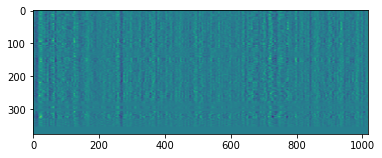

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt


indir = '../data/cme/shine/'
# 'SBJ06_Shine_375.npy'

data_mats = {}

for fname in sorted(os.listdir(indir)):
    if fname.startswith('SBJ') and fname.endswith('.npy'):
        sbj_id = fname.split("_")[0]
        d = np.load(os.path.join(indir, fname), allow_pickle=True)
        data_mats[sbj_id] = d
        

plt.imshow(data_mats['SBJ20'].T)
plt.show()


### Generate the permutations as different participants

Shuffle horizontally as chunks of data instead of random values everywhere

In [2]:
np.random.seed(seed=42)

In [9]:
from tqdm import tqdm
import math
import shutil

CHUNK_SIZE = 7
N = d.shape[0]

N_CHUNKS = math.floor(N / CHUNK_SIZE)
chunks = np.array(list(range(N_CHUNKS)))


outdir = '../data/cme/shine_shufs/'
os.makedirs(outdir, exist_ok=True)

perms = list(range(5, 21))
for perm in perms:
    outdir_perm = os.path.join(outdir, f'P{perm}')
    os.makedirs(outdir_perm, exist_ok=True)
    
    np.random.shuffle(chunks)
    
    new_data_mats = {}

    for sbj_id, d in tqdm(data_mats.items()):
        sbj_nr = int(sbj_id.replace('SBJ', ''))

        new_d = np.zeros_like(d)
        for i, chunk in enumerate(chunks):
            i_start = i * CHUNK_SIZE
            i_end = min((i+1)*CHUNK_SIZE, N)
            j_start = chunk * CHUNK_SIZE
            j_end = min((chunk+1)*CHUNK_SIZE, N)
            new_d[i_start:i_end, :] = d[j_start:j_end, :]

        new_d[N_CHUNKS * CHUNK_SIZE: , :] = d[N_CHUNKS * CHUNK_SIZE: , :]

        new_sbj_nr = sbj_nr + 70
        new_data_mats['SBJ{}'.format(new_sbj_nr)] = new_d

        np.save(os.path.join(outdir_perm, 'SBJ{}_Shine_375.npy'.format(new_sbj_nr)), new_d)
        
        cohort_in = os.path.join(outdir, 'P1', 'cohort.csv')
        cohort_out = os.path.join(outdir_perm, 'cohort.csv')
        shutil.copyfile(cohort_in, cohort_out)
        # break

100%|█████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 214.99it/s]


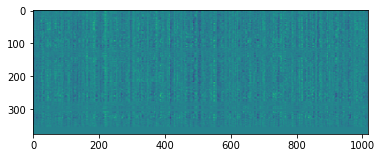

In [8]:
import matplotlib.pyplot as plt

plt.imshow(new_data_mats['SBJ71'].T)
plt.show()


### run the Mappers on the configs

The following script will generate the Mapper results, shape graphs, plots, and stats for each configuration set in the configuration.
We will run two sets of MapperToolbox configurations (they will run for a while):

```
for perm in {4..20}; do
    ./code/utils/run_mapper.sh --poolsize 4 mappers_cme.json cme-shufs $perm
done

```


### Analyze the created Mappers graphs (delay times, ...)

Once all the mappers have been computed for the configs, you should analyze the shape graphs based on the delay times criteria and the other statistics:


```
CONF=mappers_cme.json
```

Run the below for each of the above configurations:

```
source .env

FN_TIMING="$WORKSPACE/data/cme/timing.csv"
STAT_TYPE="compute_degrees_from_TCM"
CHANGE_POINTS=10
HAS_INSTRUCTIONS=1;

for perm in {4..10}; do

    # module load matlab # Maybe run this if you are running in SLURM
    DATAFOLDER="$WORKSPACE/results/cme-shufs/P${perm}/${CONF}/"
    OUTPUT_DIR="$WORKSPACE/results/cme-shufs/P${perm}/analysis/${CONF}/"
    ARGS="datafolder='${DATAFOLDER}'; fn_timing='${FN_TIMING}'; output_dir='${OUTPUT_DIR}'; stat_type='${STAT_TYPE}';"
    ARGS="$ARGS HAS_INSTRUCTIONS=${HAS_INSTRUCTIONS}; CHANGE_POINTS=${CHANGE_POINTS};"
    echo ${ARGS}
    matlab -nodesktop -r "${ARGS} run('$WORKSPACE/code/cme/deg_analysis_sbjs.m'); exit"

    echo "Done! waiting 2 second before starting next process..."
    sleep 2
    
done
```

For the rest of the criteria, run the following python script:

```
for perm in {4..10}; do

    python3 $WORKSPACE/code/utils/cache.py compute_stats \
        $WORKSPACE/data/cme/shine_shufs/P${perm}/cohort.csv \
        $WORKSPACE/results/cme-shufs/P${perm}/${CONF}/ \
        --output_dir $WORKSPACE/results/cme-shufs/P${perm}/analysis/${CONF}/

done
```

The above two commands will generate tables of stats within `analysis/${CONF}` directory. 


### Process the demapper results on the permutations

In [1]:
import csv
import os
import math
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image as IPyImage, display
from PIL import Image
from scipy import stats

sns.set(rc={'figure.facecolor':'white'})

# demapper imports for the analysis
from demapper.code.utils.analyze import extract_dataset, _handle_list_cols
from demapper.code.utils.config_cme import DATASETS, FILTERS
from demapper.code.utils.config_mapper import extract_params_f
from demapper.code.utils.utils import filter_dataframe, count_passing


In [2]:
header = ['ChangePointsIndicesError', 'passing', 'permutation']
items = []

perms = [str(p) for p in range(1, 11)] + ['N']
# perms = ['N']

for perm in perms:
    PICKED_DATASET = f'cme-shufP{perm}'
    TYPE='compute_degrees_from_TCM'
    ChangePointsError_limit = 12

    datadir = DATASETS[PICKED_DATASET]

    target_metrics_limits = {
        'ChangePointsIndicesError': [0, ChangePointsError_limit],
        'coverage_nodes-mean': [0.7, 1.0],
        'hrfdur_stat-mean': [0.15, 1.0],
        'distances_entropy-mean': [2.0, 10000.0]
    }

    stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
    results_path = os.path.join(datadir, '{0}/combined-{0}.csv'.format(TYPE))

    # Extract geodesic distances mappers
    df_bdl, _ = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][0], extract_params_f, has_sbj=False)
    df_neu, _ = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][1], extract_params_f, has_sbj=False)

    df = pd.concat([df_bdl, df_neu])
    df['passing'] = df.apply(lambda row: \
            (row['coverage_nodes-mean'] > 0.7) and \
            (row['hrfdur_stat-mean'] > 0.15) and \
            (row['distances_entropy-mean'] > 2.0), axis=1)
    max_val = df[df['ChangePointsIndicesError'] < 10000]['ChangePointsIndicesError'].max()
    df['ChangePointsIndicesError'] = df.apply(
        lambda row: row['ChangePointsIndicesError'] if row['ChangePointsIndicesError'] < 10000 else max_val, axis=1)
    df['permutation'] = perm
    items.extend(df[header].to_numpy())
    
    print(f'For permutation P{perm}')
    print('min:', np.min(df['ChangePointsIndicesError']))
    print('median:', np.median(df['ChangePointsIndicesError']))
    print('mean:', np.mean(df['ChangePointsIndicesError']))
    print('max:', np.max(df['ChangePointsIndicesError']))
    
dfc = pd.DataFrame(data=items, columns=header)
fdfc = dfc[dfc['passing'] == True]

len(stats):  96
len(results):  96
len(stats):  96
len(results):  96
For permutation P1
min: 29.7142857142857
median: 53.0
mean: 54.197916666666686
max: 119.714285714286
len(stats):  96
len(results):  96
len(stats):  96
len(results):  96
For permutation P2
min: 39.2857142857143
median: 50.5
mean: 53.02380952380954
max: 96.1428571428571
len(stats):  96
len(results):  96
len(stats):  96
len(results):  96
For permutation P3
min: 45.4285714285714
median: 110.571428571429
mean: 133.55059523809524
max: 400.0
len(stats):  96
len(results):  96
len(stats):  96
len(results):  96
For permutation P4
min: 41.7142857142857
median: 54.5714285714286
mean: 68.05654761904763
max: 267.285714285714
len(stats):  96
len(results):  96
len(stats):  96
len(results):  96
For permutation P5
min: 31.2857142857143
median: 63.64285714285715
mean: 61.96875
max: 87.4285714285714
len(stats):  96
len(results):  96
len(stats):  96
len(results):  96
For permutation P6
min: 35.8571428571429
median: 63.571428571428555
mean:

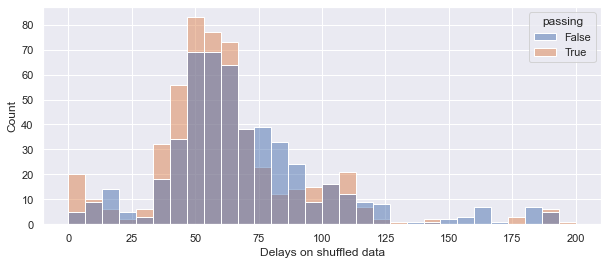

In [3]:
_, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=1)

sns.histplot(dfc, x='ChangePointsIndicesError', hue='passing', bins=30, ax=ax, binrange=(0,200))
ax.set_xlabel('Delays on shuffled data')
plt.show()

In [10]:
dfc_np = dfc[dfc['permutation'] == 'N']
dfc_perms = dfc[dfc['permutation'] != 'N']
fdfc_np = fdfc[fdfc['permutation'] == 'N']
fdfc_perms = fdfc[fdfc['permutation'] != 'N']

# for i,df in enumerate([dfc_perms, fdfc_perms, dfc_np, fdfc_np]):
for i,df in enumerate([fdfc_perms, fdfc_np]):
    print(i, len(df))
    print(np.min(df['ChangePointsIndicesError']))
    print(np.median(df['ChangePointsIndicesError']))
    print(np.mean(df['ChangePointsIndicesError']))
    print(np.max(df['ChangePointsIndicesError']))


0 498
29.7142857142857
59.35714285714285
70.6348250143431
400.0
1 38
2.57142857142857
6.357142857142859
8.473684210526315
22.4285714285714


In [ ]:
df.groupby('permutation').min()

,ChangePointsIndicesError,passing
permutation,,
1,29.714286,True
2,39.285714,True
3,80.142857,True


In [ ]:
from tqdm import tqdm

outdir = '../data/cme/shine_shuf/'
new_data_mats = {}

for sbj_id, d in tqdm(data_mats.items()):
    sbj_nr = int(sbj_id.replace('SBJ', ''))
    
    new_d = data_mats[sbj_id].copy()
    changes = {}
    sh = new_d.shape
    N = np.prod(sh)
    for _ in range(2 * N):
        i1 = np.random.randint(sh[0])
        j1 = np.random.randint(sh[1])
        i2 = np.random.randint(sh[0])
        j2 = np.random.randint(sh[1])
        changes[(i1, j1)] = 1
        changes[(i2, j2)] = 1

        sw = new_d[i1,j1]
        new_d[i1,j1] = new_d[i2,j2]
        new_d[i2,j2] = sw
        
        if len(changes) > N * 0.95:
            break
            
    new_data_mats['SBJ{}'.format(sbj_nr+50)] = new_d
            
    np.save(os.path.join(outdir, 'SBJ{}_Shine_375.npy'.format(sbj_nr + 50)), new_d)